In [7]:
import os
import sys
import pandas as pd
import re

In [8]:
test_df = pd.concat([
    pd.read_csv('../../data/spanish/test.csv'),
    pd.read_csv('../../data/german/test.csv'),
    pd.read_csv('../../data/french/test.csv')
], ignore_index=True)
train_df = pd.concat([
    pd.read_csv('../../data/spanish/train.csv'),
    pd.read_csv('../../data/german/train.csv'),
    pd.read_csv('../../data/french/train.csv')
], ignore_index=True)
val_df = pd.concat([
    pd.read_csv('../../data/spanish/valid.csv'),
    pd.read_csv('../../data/german/valid.csv'),
    pd.read_csv('../../data/french/valid.csv')
], ignore_index=True)


test_df.head()

,text,label,source
0,"@user jajajaja dale, hacete la boluda vos jaja...",negative,intertass_2017
1,cada vez que cito un tweet se va la ubicación ...,neutral,intertass_2017
2,@user MAAAAE RAJADO! Pero lo bueno es q uno se...,positive,intertass_2017
3,Bueno hoy fui a almorzar a Nanay con otras 3 d...,negative,intertass_2017
4,Necesito seguir a mas cuentas camren shippers ...,neutral,intertass_2017


In [9]:
from sklearn.model_selection import train_test_split

train_df, _ = train_test_split(
    train_df,
    test_size = 0.6 ,
    stratify = train_df['label'],
    random_state = 42
)

In [10]:
train_df = train_df[train_df["label"] != "neutral"]
test_df  = test_df[test_df["label"]  != "neutral"]
val_df   = val_df[val_df["label"]   != "neutral"]

mapping = {'negative': 0, 'positive': 1}

# Create a new column with mapped values
train_df['sentiment_num'] = train_df['label'].map(mapping)
test_df['sentiment_num'] = test_df['label'].map(mapping)
val_df['sentiment_num'] = val_df['label'].map(mapping)

In [11]:
url_pattern = re.compile(r"http\S+|www\.\S+")
mention_pattern = re.compile(r"@\w+")
hashtag_pattern = re.compile(r"#(\w+)")
rt_pattern = re.compile(r"^RT\s+@\w+:\s*")

def normalize_elongation(word, max_repeat=2):
    return re.sub(r"(.)\1{"+str(max_repeat)+r",}", r"\1"*max_repeat, word)

def clean_tweet(text: str) -> str:
    if not isinstance(text, str):
        return ""
    
    text = rt_pattern.sub("", text)
    text = url_pattern.sub(" URL ", text)
    text = mention_pattern.sub(" @usuario ", text)
    text = hashtag_pattern.sub(r"\1", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.lower()
    tokens = []
    for tok in text.split():
        tokens.append(normalize_elongation(tok))
    text = " ".join(tokens)

    return text



train_df["clean_text"] = train_df["text"].apply(clean_tweet)
test_df["clean_text"] = test_df["text"].apply(clean_tweet)
val_df["clean_text"] = val_df["text"].apply(clean_tweet)

In [12]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW
from datasets import Dataset

model_name = "bert-base-multilingual-uncased"
tok = BertTokenizer.from_pretrained(model_name)
MAX_LEN = 128

def tokenize(batch):
    return tok(
        batch["text"].tolist(),
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

train_encodings = tokenize(train_df)
val_encodings = tokenize(val_df)
test_encodings = tokenize(test_df)


/opt/miniconda3/envs/mbertproj/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/mbertproj/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = SentimentDataset(train_encodings, train_df["sentiment_num"].values)
val_dataset = SentimentDataset(val_encodings, val_df["sentiment_num"].values)
test_dataset = SentimentDataset(test_encodings, val_df["sentiment_num"].values)

In [14]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, shuffle = True)
#change number of labels based on keep/drop neutral class
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir="results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/envs/mbertproj/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 20%|██        | 92/460 [01:12<04:49,  1.27it/s]

{'loss': 0.6393, 'grad_norm': 20.878440856933594, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}


                                                
 20%|██        | 92/460 [01:21<04:49,  1.27it/s]

{'eval_loss': 0.5003387928009033, 'eval_runtime': 8.4392, 'eval_samples_per_second': 76.784, 'eval_steps_per_second': 4.858, 'epoch': 1.0}


 40%|████      | 184/460 [03:01<06:01,  1.31s/it]

{'loss': 0.3979, 'grad_norm': 10.03799819946289, 'learning_rate': 1.2e-05, 'epoch': 2.0}


                                                 
 40%|████      | 184/460 [03:09<06:01,  1.31s/it]

{'eval_loss': 0.4956975281238556, 'eval_runtime': 8.2631, 'eval_samples_per_second': 78.421, 'eval_steps_per_second': 4.962, 'epoch': 2.0}


 60%|██████    | 276/460 [04:27<02:32,  1.21it/s]

{'loss': 0.2156, 'grad_norm': 6.877910137176514, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}


                                                 
 60%|██████    | 276/460 [04:36<02:32,  1.21it/s]

{'eval_loss': 0.6161461472511292, 'eval_runtime': 9.5143, 'eval_samples_per_second': 68.108, 'eval_steps_per_second': 4.309, 'epoch': 3.0}


 80%|████████  | 368/460 [06:05<01:27,  1.05it/s]

{'loss': 0.106, 'grad_norm': 2.0081419944763184, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


                                                 
 80%|████████  | 368/460 [06:15<01:27,  1.05it/s]

{'eval_loss': 0.8663480877876282, 'eval_runtime': 10.5425, 'eval_samples_per_second': 61.465, 'eval_steps_per_second': 3.889, 'epoch': 4.0}


100%|██████████| 460/460 [07:49<00:00,  1.07it/s]

{'loss': 0.0511, 'grad_norm': 38.785682678222656, 'learning_rate': 0.0, 'epoch': 5.0}


                                                 
100%|██████████| 460/460 [07:59<00:00,  1.07it/s]

{'eval_loss': 0.9353488683700562, 'eval_runtime': 9.7642, 'eval_samples_per_second': 66.365, 'eval_steps_per_second': 4.199, 'epoch': 5.0}


100%|██████████| 460/460 [08:01<00:00,  1.05s/it]

{'train_runtime': 481.7451, 'train_samples_per_second': 15.267, 'train_steps_per_second': 0.955, 'train_loss': 0.28198558143947433, 'epoch': 5.0}


TrainOutput(global_step=460, training_loss=0.28198558143947433, metrics={'train_runtime': 481.7451, 'train_samples_per_second': 15.267, 'train_steps_per_second': 0.955, 'total_flos': 483795453043200.0, 'train_loss': 0.28198558143947433, 'epoch': 5.0})

In [15]:
metrics = trainer.evaluate()
print(metrics)

100%|██████████| 41/41 [00:10<00:00,  3.98it/s]

{'eval_loss': 0.9353488683700562, 'eval_runtime': 10.3291, 'eval_samples_per_second': 62.736, 'eval_steps_per_second': 3.969, 'epoch': 5.0}


In [16]:
predictions = trainer.predict(val_dataset)

100%|██████████| 41/41 [00:11<00:00,  3.47it/s]


In [17]:
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, classification_report

logits = predictions.predictions      # or predictions[0]
labels = predictions.label_ids        # or predictions[1]

y_pred = np.argmax(logits, axis=-1)

print("Accuracy:", accuracy_score(labels, y_pred))
print("F1 (macro):", f1_score(labels, y_pred, average="macro"))

print(
    classification_report(
        labels,
        y_pred,
        #target_names=["negative", "neutral", "positive"]
        target_names=["negative","positive"]
    )
)

Accuracy: 0.7962962962962963
F1 (macro): 0.7960612274092795
              precision    recall  f1-score   support

    negative       0.78      0.83      0.80       324
    positive       0.82      0.76      0.79       324

    accuracy                           0.80       648
   macro avg       0.80      0.80      0.80       648
weighted avg       0.80      0.80      0.80       648



Test Dataset

In [18]:
pred = trainer.predict(test_dataset)
y_true = test_df["sentiment_num"]
y_pred = np.argmax(pred.predictions, axis=1)


logits = pred.predictions   
labels = pred.label_ids   


print("Accuracy:", accuracy_score(labels, y_pred))
print("F1 (macro):", f1_score(labels, y_pred, average="macro"))

print(
    classification_report(
        labels,
        y_pred,
        #target_names=["negative", "neutral", "positive"]
        target_names=["negative","positive"]
    )
)

100%|██████████| 41/41 [00:11<00:00,  3.50it/s]

Accuracy: 0.7561728395061729
F1 (macro): 0.7547124608293164
              precision    recall  f1-score   support

    negative       0.72      0.83      0.77       324
    positive       0.80      0.68      0.74       324

    accuracy                           0.76       648
   macro avg       0.76      0.76      0.75       648
weighted avg       0.76      0.76      0.75       648



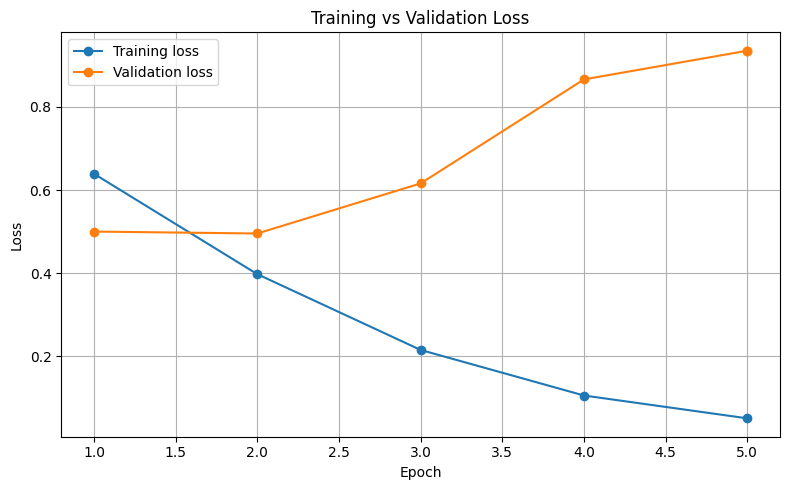

In [19]:
import matplotlib.pyplot as plt

# After training:
# trainer.train()

logs = pd.DataFrame(trainer.state.log_history)

# Separate train and eval logs
train_logs = logs[logs["loss"].notna()][["epoch", "loss"]]
eval_logs  = logs[logs["eval_loss"].notna()][["epoch", "eval_loss"]]

plt.figure(figsize=(8, 5))

plt.plot(train_logs["epoch"], train_logs["loss"], marker="o", label="Training loss")
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], marker="o", label="Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()